In [1]:
import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.config.run_functions_eagerly(True)
from PIL import Image
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import os, random

In [2]:
# # Forbidden GPUs
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# set gpus memory used by growth
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
batch = 10
inh = 180
inw = 390
inc = 3
upscale = 2

In [4]:
class FSR(tf.keras.models.Model):
    def __init__(self,upscale):
        # 调用父类__init__()方法
        super(FSR, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(48, 3, strides=1, padding='same', activation=None, name="linear_conv1")
        self.conv2d_2 = tf.keras.layers.Conv2D(48, 5, strides=1, padding='same', activation='tanh', name="nonlinear_conv1")
        self.conv2d_3 = tf.keras.layers.Conv2D(48, 3, strides=1, padding='same', activation='tanh', name="nonlinear_conv2")
        self.conv2d_4 = tf.keras.layers.Conv2D(48, 3, strides=1, padding='same', activation='tanh', name="nonlinear_conv3")
        self.conv2d_5 = tf.keras.layers.Conv2D(3*upscale*upscale, 3, strides=1, padding='same', activation=None, name="conv")
        # self.conv2d_6 = tf.keras.layers.Conv2D(3, 3, strides=1, padding='same', activation='tanh', name="conv_last")
        self.r = upscale
        #print("Model inited.")

    def call(self, inputs):
        inputs = inputs/127.5 - 1
        linear_conv = self.conv2d_1(inputs)
        nonlinear_conv = self.conv2d_2(inputs)
        nonlinear_conv = self.conv2d_3(nonlinear_conv)
        nonlinear_conv = self.conv2d_4(nonlinear_conv)
        # fea = tf.concat([linear_conv,nonlinear_conv], axis=3)
        fea = linear_conv + nonlinear_conv
        fea = self.conv2d_5(fea)
        # Pixel Shuffle
        xc = []
        for c in range(3):
            t = fea[:,:,:,c*self.r*self.r:c*self.r*self.r+self.r*self.r] # [B,H,W,R*R]
            t = tf.compat.v1.depth_to_space(t, self.r) # [B,H*R,W*R,1]
            xc += [t]
        x = tf.concat(xc, axis=3)   # [B,H*R,W*R,3]
        x = tf.clip_by_value(x, -1, 1)
        x = (x+1)*127.5
        return x

In [5]:
fsr = FSR(upscale)
fsr.build(input_shape=(batch,inh,inw,inc))
print(fsr.summary())

Model: "fsr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
linear_conv1 (Conv2D)        multiple                  1344      
_________________________________________________________________
nonlinear_conv1 (Conv2D)     multiple                  3648      
_________________________________________________________________
nonlinear_conv2 (Conv2D)     multiple                  20784     
_________________________________________________________________
nonlinear_conv3 (Conv2D)     multiple                  20784     
_________________________________________________________________
conv (Conv2D)                multiple                  5196      
Total params: 51,756
Trainable params: 51,756
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
def Huber(y_true, y_pred, delta=0.1, axis=None):
    abs_error = tf.abs(y_pred - y_true)
    quadratic = tf.minimum(abs_error, delta)
    # The following expression is the same in value as
    # tf.maximum(abs_error - delta, 0), but importantly the gradient for the
    # expression when abs_error == delta is 0 (for tf.maximum it would be 1).
    # This is necessary to avoid doubling the gradient, since there is already a
    # nonzero contribution to the gradient from the quadratic term.
    linear = (abs_error - quadratic)
    losses = 0.5 * quadratic**2 + delta * linear
    return tf.reduce_mean(losses, axis=axis)

In [7]:
fsr.compile(optimizer='adam',
              loss=Huber,
              metrics=['accuracy'])

In [8]:
def generator(inpath,outpath,batch_size,reshuffle_each_iteration=False):
    # read and sort train data from dir
    x_train_lr_list = os.listdir(inpath)
    x_train_lr_list.sort(key=lambda x:int(x[5:-4]))#倒着数第四位'.'为分界线，按照‘.’左边的数字从小到大排序
    x_train_lr_list = [os.path.join(inpath,c) for c in x_train_lr_list]
    y_train_list = os.listdir(outpath)
    y_train_list.sort(key=lambda x:int(x[5:-4]))
    y_train_list = [os.path.join(outpath,c) for c in y_train_list]
    i = 0
    while True:
        x_train_lr, y_train = loadimgs_from_paths(
            x_train_lr_list[i*batch_size:(i+1)*batch_size], y_train_list[i*batch_size:(i+1)*batch_size])
        yield np.float32(x_train_lr), np.float32(y_train)
        i = (i+1) % (len(x_train_lr_list) // batch_size)
        # print(len(x_train_lr_list) // batch_size)
        if reshuffle_each_iteration:
            if i == 0:
                paths = list(zip(x_train_lr_list, y_train_list))
                random.shuffle(paths)
                x_train_lr_list, y_train_list = zip(*paths)

In [9]:
history = fsr.fit(generator("../data/540cut","../data/1080cut",batch),steps_per_epoch=100, epochs=100, verbose=1)

Epoch 1/100
100/100 [==============================] - 15s 146ms/step - loss: 0.6470 - accuracy: 0.8698
Epoch 2/100
100/100 [==============================] - 14s 144ms/step - loss: 0.2493 - accuracy: 0.9644
Epoch 3/100
100/100 [==============================] - 15s 145ms/step - loss: 0.2148 - accuracy: 0.9739
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2087 - accuracy: 0.9752
Epoch 5/100
100/100 [==============================] - 15s 148ms/step - loss: 0.1904 - accuracy: 0.9793
Epoch 6/100
100/100 [==============================] - 15s 149ms/step - loss: 0.1813 - accuracy: 0.9805
Epoch 7/100
100/100 [==============================] - 15s 149ms/step - loss: 0.1698 - accuracy: 0.9845
Epoch 8/100
100/100 [==============================] - 15s 146ms/step - loss: 0.1726 - accuracy: 0.9844
Epoch 9/100
100/100 [==============================] - 14s 140ms/step - loss: 0.1797 - accuracy: 0.9836
Epoch 10/100
100/100 [==============================] - 14s 141m

100/100 [==============================] - 15s 152ms/step - loss: 0.1505 - accuracy: 0.9898
Epoch 80/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1470 - accuracy: 0.9906
Epoch 81/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1482 - accuracy: 0.9905
Epoch 82/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1473 - accuracy: 0.9902
Epoch 83/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1487 - accuracy: 0.9897
Epoch 84/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1470 - accuracy: 0.9902
Epoch 85/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1438 - accuracy: 0.9906
Epoch 86/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1439 - accuracy: 0.9904
Epoch 87/100
100/100 [==============================] - 15s 151ms/step - loss: 0.1390 - accuracy: 0.9910
Epoch 88/100
100/100 [==============================] - 15s 151ms/st

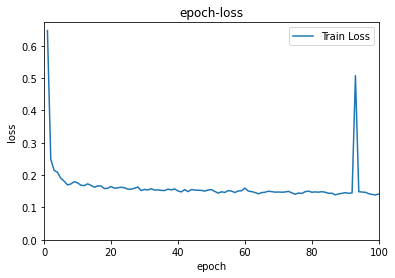

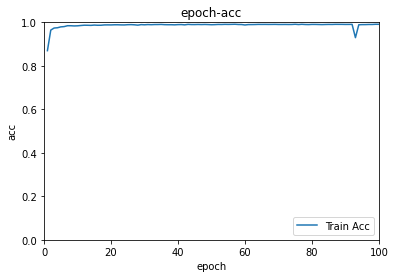

In [10]:
# Visualization
epochs = 100
l = np.array(history.history['loss'])
a = np.array(history.history['accuracy'])
step = np.linspace(1,epochs,epochs)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, epochs))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./train-loss.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, epochs))
plt.ylim((0., 1))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./train-acc.png', bbox_inches='tight')
plt.show()

In [11]:
fsr.save_weights("./model/fsr2x")